In [1]:
from matplotlib import pyplot as plt
import sncosmo
from sntd import simulation, fitting,io,ml
from sntd.plotting import _COLORLIST5
import sys,pyParz
from copy import deepcopy
import numpy as np
from astropy.io import ascii
from scipy.interpolate import splrep,splev
from scipy.optimize import minimize,minimize_scalar
from scipy.interpolate import interp1d
import extinction
from sncosmo.utils import integration_grid
from sncosmo.constants import HC_ERG_AA, MODEL_BANDFLUX_SPACING
from statsmodels.stats.stattools import durbin_watson


In [2]:
reload(ml)
fitData=[]
gamma=[.27,.33,.76,.93]
kappas=[.3,.36,.75,.87]
fstar=[.38,.49,.8,.72]
kappac=[(1-fstar[i])*kappas[i] for i in range(len(kappas))]
for i in range(len(gamma)):
    if i!=2:
        continue
    fitData.append(ml.realizeMicro(kappas=.5,gamma=.5,kappac=.25))

In [13]:
reload(ml)
mlList=[]
for i in range(len(fitData)):
    mlList.append([])
    for j in range(1000):
        time,dmag=ml.microcaustic_field_to_curve(fitData[i],np.arange(10,50,1),.5,1.3)
        mlList[i].append(dmag)

In [ ]:
fig,ax=plt.subplots(nrows=2,ncols=2,sharex=True,sharey=False,figsize=(20,30))
row=0
col=0
for i in range(len(fitData)):
    if i==1 or i==3:
        col=1
    elif i==2:
        row=1
        col=0
    for mag in mlList[i]:
        ax[row][col].plot(time,mag,color='k')
    ax[row][col].plot([29.5,29.5],ax[row][col].get_ylim(),'r--')
    ax[row][col].invert_yaxis()
plt.show()
plt.clf()
plt.close()

In [ ]:
fig,ax=plt.subplots(nrows=2,ncols=2,sharex=True,sharey=False,figsize=(20,30))
row=0
col=0
for i in range(len(fitData)):
    if i==1 or i==3:
        col=1
    elif i==2:
        row=1
        col=0
    for mag in mlList[i]:
        ax[row][col].plot(time,mag-np.median(mag),color='k')
    ax[row][col].plot([29.5,29.5],ax[row][col].get_ylim(),'r--')
    ax[row][col].invert_yaxis()
plt.show()
plt.clf()
plt.close()

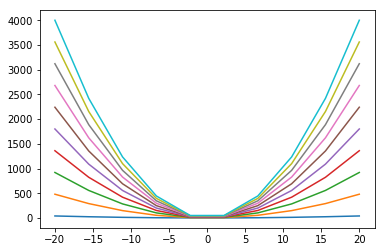

In [10]:
fig=plt.figure()
ax=fig.gca()
x=np.linspace(-20,20,10)
for amp in np.linspace(.1,10,10):
    ax.plot(x,amp*x**2)
plt.show()
plt.close()

In [ ]:
reload(simulation)
reload(sncosmo)
reload(fitting)
modname ='snana-2004gv'#
snType = 'Ib'
#bandlist = ['bessellb', 'bessellv', 'bessellr']
bandlist = ['F110W']
mF110W = np.array([25.0, 25.5, 25.8, 26.1, 26.4, 26.7, 27.0, 27.3, 27.6, 28.5])
SNR04  = np.array([25.8, 16.5, 12.6,  9.6,  7.3,  5.5,  4.2,  3.2,  2.4,  1.1])
stats=[]
deltas=[]
all_lcs1=[]
all_lcs2=[]
all_orig=[]
nsim=100
for i in range(nsim):
    modname ='snana-2004gv'
    print(i)
    go=True
    while go:
        lcs = simulation.createMultiplyImagedSN(
            modname, snType, 1.33,z_lens=.53, bands=bandlist,
            zp=[26.8], cadence=5., epochs=30.,skynoiseRange=(.001,.005),gain=70. , time_delays=[10., 78.],
            magnifications=[10,5], objectName='BELLS J0830+5116--Type Ia', telescopename='HST',
            microlensing_type='AchromaticMicrolensing',scatter=True,av_host=None,
            microlensing_params=fitData[0],minsnr=5.0,snrFunc=interp1d(mF110W,SNR04,'quadratic'))
        if lcs is not None:
            keep=0
            for k in lcs.images.keys():
                lcs.images[k].table=lcs.images[k].table[lcs.images[k].table['time']<{'S1':10,'S2':78}[k]+50]
                lcs.images[k].table=lcs.images[k].table[lcs.images[k].table['time']>{'S1':10,'S2':78}[k]-25]
                if len(lcs.images[k].table)==0:
                    keep+=1
            if keep==0:
                go=False
    all_orig.append(lcs)
    #lcs.plot_object(showfig=True,savefig=True,showmodel=True)
    #plt.show()
    
    
    mods=['2006ep','2007Y','2005hm','2006jo','2007nc']
    modname=[modname]#['snana-'+m for m in mods]
    pre=fitting.fit_data(lcs, snType='Ib', models=modname,bands=bandlist,
                                    params=['amplitude','t0'],
                                    constants={'z':1.33},
                                    bounds={'t0':(-10,10)},#t0_guess={'S1':10,'S2':78},
                                    combined_or_separate='separate',showPlots=False,microlensing=None)
    #for k in lcs_tdfit.images.keys():
    #    print(lcs_tdfit.images[k].fits.res.logz)
    all_lcs1.append(pre.images['S2'].fits.model.get('t0')-pre.images['S1'].fits.model.get('t0'))
    lcs_tdfit=fitting.fit_data(lcs, snType='Ib', models=modname,bands=bandlist,
                                    params=['amplitude','t0'],
                                    constants={'z':1.33},#t0_guess={'S1':10,'S2':78},
                                    bounds={'t0':(-10,10)},#{'t0':(-.000001,.000001)},
                                    combined_or_separate='separate',showPlots=False,microlensing='achromatic')
    all_lcs2.append(lcs_tdfit.images['S2'].fits.model.get('t0')-lcs_tdfit.images['S1'].fits.model.get('t0'))
    '''
    for k in lcs_tdfit.images.keys():
        if k=='S1':
            t=np.arange(0,20,.1)
        else:
            t=np.arange(68,88,.1)
        f=lcs_tdfit.images[k].fits.model.bandflux('F110W',t,zp=26.8,zpsys='AB')
        fb= lcs_tdfit.images[k].fits.model.bandflux('bessellb',t,zp=25.0,zpsys='AB')
        print(t[f==np.max(f)],t[fb==np.max(fb)],lcs_tdfit.images[k].fits.model.get('t0'))
        fig=plt.figure()
        ax=fig.gca()
        ax.plot(lcs_tdfit.images[k].fits.model._source._phase,
                lcs_tdfit.images[k].fits.model.bandflux('F110W',lcs_tdfit.images[k].fits.model._source._phase,zp=26.8,zpsys='AB'),label='Microlensing')
        f=pre.images[k].fits.model.bandflux('F110W',t,zp=26.8,zpsys='AB')
        fb= pre.images[k].fits.model.bandflux('bessellb',t,zp=25.0,zpsys='AB')
        f3=lcs.images[k].simMeta['model'].bandflux('F110W',t,zp=26.8,zpsys='AB')
        
        print(t[f==np.max(f)],t[fb==np.max(fb)],pre.images[k].fits.model.get('t0'))
        print(t[f3==np.max(f3)])
        ax.plot(pre.images[k].fits.model._source._phase,
                pre.images[k].fits.model.bandflux('F110W',pre.images[k].fits.model._source._phase,zp=26.8,zpsys='AB'),label='No Microlensing')
        ax.scatter(lcs.images[k].table['time'],lcs.images[k].table['flux'])
        ax.plot(lcs.images[k].simMeta['model']._source._phase,lcs.images[k].simMeta['model'].bandflux('F110W',lcs.images[k].simMeta['model']._source._phase,zp=26.8,zpsys='AB'),label='actual')
        if k=='S1':
            ax.set_xlim((-10,60))
        else:
            ax.set_xlim((58,128))
        ax.legend()
        plt.show()
        
    
    for k in lcs.images.keys():
        mlDiff=lcs_tdfit.images[k].fits.model.get('amplitude')/(lcs.model.get('amplitude')*lcs.images[k].simMeta['mu'])
        tempTime=lcs.images[k].table['time']-{'S1':10,'S2':78}[k]
        tempTime=tempTime[tempTime>=-15]
        tempTime=tempTime[tempTime<=40]
        fig=plt.figure()
        ax=fig.gca()
        ax.plot(tempTime,10**(-.4*lcs.images[k].simMeta['microlensing_params'](tempTime/(1+1.33)))/mlDiff)
        ax.set_xlim((-10,50))
        #ax.set_ylim((-.1,.1))
        plt.show()
    '''
    
#lcs_tdfit=fitting.fit_data(lcs, snType='Ib', models=[modname],bands=bandlist,
#                                params=['amplitude','t0','hostebv'],
#                                constants={'z':1.33,'hostr_v':3.1},t0_guess={'S1':10,'S2':78},
#                                bounds={'t0':(-.001,.001),'hostebv':(0,.2)},
#                                effect_frames=['rest'],effect_names=['host'],dust='CCM89Dust',
#                                combined_or_separate='separate',showPlots=True)

0


In [50]:
noScatter1=deepcopy(all_lcs1)
noScatter2=deepcopy(all_lcs2)

(1.5451472770699834, 1.2638234682458813)
(68.21202799163586, 67.95873940520457)


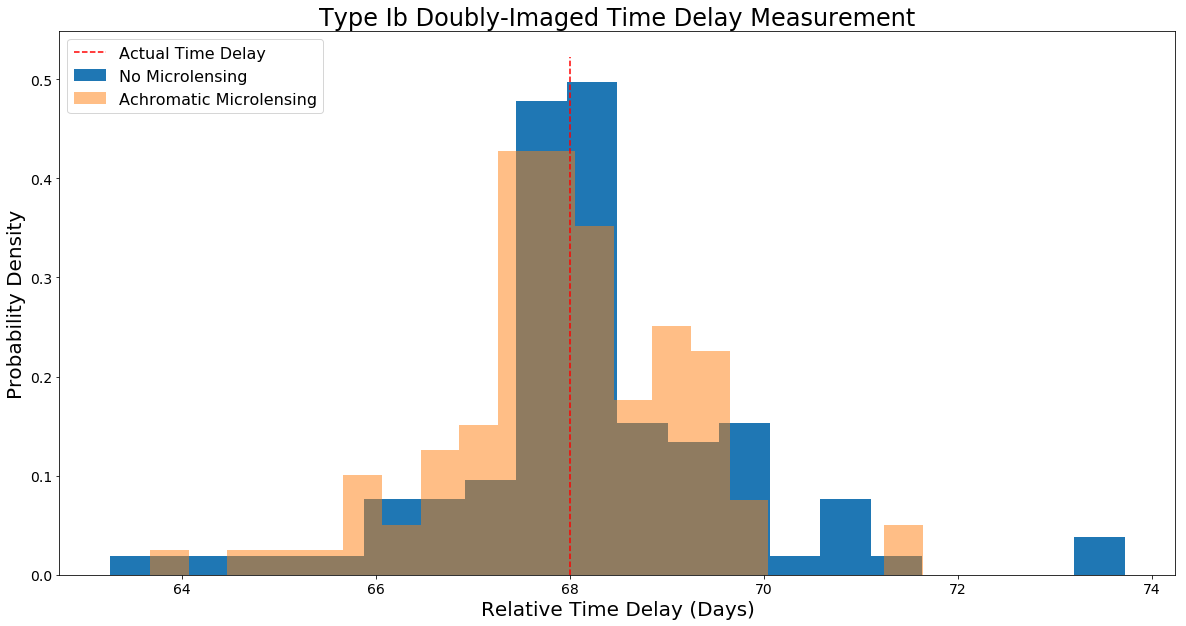

In [51]:

print(np.std(noScatter1),np.std(noScatter2))
print(np.mean(noScatter1),np.mean(noScatter2))
fig=plt.figure(figsize=(20,10)) 
ax=fig.gca() 

ax.hist(noScatter1, bins=nsim/5, normed=True,label='No Microlensing')
ax.hist(noScatter2, bins=nsim/5, normed=True,label='Achromatic Microlensing',alpha=.5)
ax.plot([68,68],ax.get_ylim(),'r--',label='Actual Time Delay') 
ax.legend(loc='upper left',fontsize=16) 
ax.set_title('Type Ib Doubly-Imaged Time Delay Measurement',size=24) 
ax.set_ylabel('Probability Density',size=20) 
ax.set_xlabel('Relative Time Delay (Days)',size=20) 
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
plt.show()

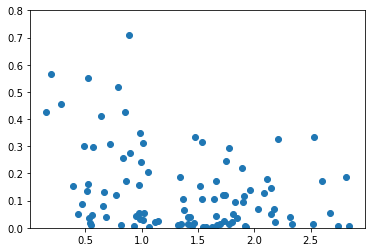

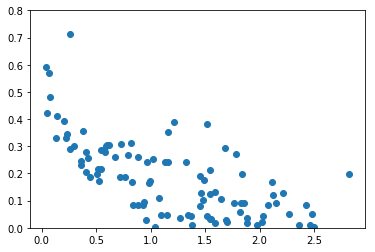

In [110]:
for i in range(2):
    fig=plt.figure()
    ax=fig.gca()
    ax.scatter([x[i] for x in stats],[x[i] for x in deltas])
    ax.set_ylim((0,.8))
    #ax.set_xlim((0,1))
    plt.show()
    plt.close()


In [ ]:


def reddening(band):
    band=sncosmo.get_bandpass(band)
    wave, dwave = integration_grid(band.minwave(), band.maxwave(),MODEL_BANDFLUX_SPACING)
    f0=np.ones(len(wave))
    f=extinction.apply(extinction.ccm89(wave,.3,3.1),f0)
    return(np.sum(wave * band(wave) * f)/np.sum(wave*band(wave)*f0))

for i in range(len(stats)):

    if np.min(stats[i])>.5:
        continue
    print(stats[i])
    row=-1
    fig,ax=plt.subplots(nrows=2,ncols=3,sharex=False,sharey=False,figsize=(12,12))
    lcs_tdfit=all_lcs[i]
    lcs=all_orig[i]
    durb=False
    for k in lcs.images.keys():
            row+=1
            col=0
            lcs.images[k].table=lcs.images[k].table[lcs.images[k].table['flux']>.01]
            #lcs.images[k].table=lcs.images[k].table[lcs.images[k].table['time']>-15+lcs_tdfit.images[k].fits.model.get('t0')]
            #lcs.images[k].table=lcs.images[k].table[lcs.images[k].table['time']<60+lcs_tdfit.images[k].fits.model.get('t0')]
            for b in bandlist:

                tempTime=lcs.images[k].table['time'][lcs.images[k].table['band']==b]-lcs_tdfit.images[k].fits.model.get('t0')
                resid=-2.5*np.log10(lcs.images[k].table['flux'][lcs.images[k].table['band']==b])+2.5*np.log10(lcs_tdfit.images[k].fits.model.bandflux(b,tempTime+lcs_tdfit.images[k].fits.model.get('t0'),
                            zpsys='AB',zp=lcs.images[k].zp[b]))
                if durbin_watson(resid)<=1 or True:
                    durb=True
                ax[row][col].scatter(tempTime,resid)
                            #1.0857 *lcs.images[k].table['fluxerr']/lcs.images[k].table['flux'],fmt='r.')
                #print((lcs.images[k].table['time']-lcs_tdfit.images[k].fits.model.get('t0')-
                #                                                 lcs_tdfit.images[k].fits.model._source._phase[0])/(1+.53))
                ml=lcs.images[k].simMeta['microlensing_params'](tempTime/(1+1.33))
                mu=lcs.images[k].simMeta['mu']
                mlDiff=lcs_tdfit.images[k].fits.model.get('amplitude')/(lcs.model.get('amplitude')*mu)
                #print(mu,lcs_tdfit.images[k].fits.model.get('amplitude')/(lcs.model.get('amplitude')),
                #     mlDiff)
                #print(-2.5*np.log10(lcs.images[k].table['flux'][lcs.images[k].table['band']==b])+lcs.images[k].table['zp'][0]+2.5*np.log10(lcs_tdfit.images[k].fits.model.bandflux(b,tempTime+lcs_tdfit.images[k].fits.model.get('t0'),
                #            zpsys='AB',zp=lcs.images[k].table['zp'][0]))-lcs.images[k].table['zp'][0])
                #sys.exit()
                #ax[row][col].plot(tempTime,(ml-np.median(ml)),label='med')
                #ax[row][col].plot(tempTime,(ml-np.mean(ml)),label='mean')
                ax[row][col].plot(tempTime,ml+2.5*np.log10(mlDiff))#+2.5*np.log10(reddening(b)))
                
                #print(durbin_watson(resid))
                #phi=testing(resid,tempTime)
                #print(phi)
                #iar=final(phi,resid,tempTime)
                #ax.plot(tempTime[:-1],iar)
                #ax.plot(tempTime,(ml-np.mean(ml)),label='mean')
                spl=splrep(tempTime,resid,s=len(tempTime)/2,k=1)
                ax[row][col].plot(tempTime,splev(tempTime,spl))
                ax[row][col].legend()
                ax[row][col].plot(ax[row][col].get_xlim(),[0,0])
                ax[row][col].invert_yaxis()
                col=1
                ax[row][col].plot(tempTime,ml)#10**(-.4*ml))
                ax[row][col].invert_yaxis()
            ax[row][2].plot(np.arange(-20,150,1),lcs.images[k].simMeta['microlensing_params'](np.arange(-20,150,1)))
            ax[row][2].invert_yaxis()    
            
    if durb:    
        plt.show()
    else:
        plt.clf()
    plt.close()


(1000,)
((1000, 1), (1000,))


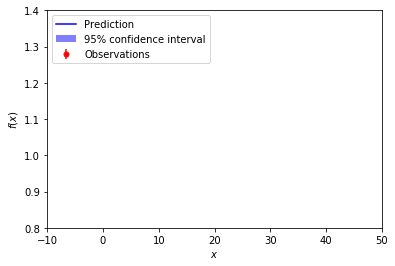

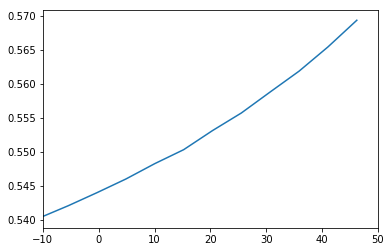

In [343]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C



# ----------------------------------------------------------------------
# now the noisy case

b='F110W'
k='S1'
#for i in range(100):
#    if np.abs(np.max(lcs.images[k].simMeta['microlensing_params'](tempTime/(1+1.33)))-
#              np.min(lcs.images[k].simMeta['microlensing_params'](tempTime/(1+1.33))))>.03:#durbin_watson(lcs.images[k].simMeta['microlensing_params'](tempTime/(1+1.33)))<.1:
#        #print(np.max(lcs.images[k].simMeta['microlensing_params'](tempTime/(1+1.33))),np.min(lcs.images[k].simMeta['microlensing_params'](tempTime/(1+1.33))))
#        break
i=0#29
lcs_tdfit=all_lcs[i]
lcs=all_orig[i]
lcs.images[k].table=lcs.images[k].table[lcs.images[k].table['flux']>.01]
    
tempTime=lcs.images[k].table['time'][lcs.images[k].table['band']==b]-lcs_tdfit.images[k].fits.model.get('t0')
X=tempTime
resid=lcs.images[k].table['flux'][lcs.images[k].table['band']==b]/lcs_tdfit.images[k].fits.model.bandflux(b,tempTime+lcs_tdfit.images[k].fits.model.get('t0'),
            zpsys='AB',zp=lcs.images[k].zp[b])
#X = np.linspace(0.1, 9.9, 20)
X = np.atleast_2d(X).T
mlDiff=lcs_tdfit.images[k].fits.model.get('amplitude')/(lcs.model.get('amplitude')*mu)


kernel = RBF(10., (5., 40.))# C(.1, (1e-4, 10.)) * 

# Observations and noise
#y = f(X).ravel()
y=resid.ravel()
#dy = 0.5 + 1.0 * np.random.random(y.shape)
dy=lcs.images[k].table['fluxerr']/lcs.images[k].table['flux']
#noise = np.random.normal(0, dy)
#y += noise

# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy ** 2,
                              n_restarts_optimizer=100)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

x = np.atleast_2d(np.linspace(np.min(tempTime), np.max(tempTime), 1000)).T
# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)
print(sigma.shape)
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
#plt.plot(X, resid, 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label=u'Observations')
print(x.shape,y_pred.shape)
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.xlim(-10, 50)
plt.ylim(.8, 1.4)
plt.legend(loc='upper left')

fig=plt.figure()
ax=fig.gca()
ax.plot(tempTime,10**(-.4*lcs.images[k].simMeta['microlensing_params'](tempTime/(1+1.33)))/mlDiff)
ax.set_xlim((-10,50))
#ax.set_ylim((-.1,.1))
plt.show()